# Exploratory data analysis of the Steam dataset

Dataset from: https://www.kaggle.com/tamber/steam-video-games

### Dataset description (from the dataset author):
Steam is the world's most popular PC Gaming hub. With a massive collection that includes everything from AAA blockbusters to small indie titles, great discovery tools can be super valuable for Steam. How can we make them better?

This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, value. The behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.

### Basic modifications

The value for the `purchase` is always 1. Since it is redundant we can delete all `purchase`, and therefore the `behavior-name` column as well. We will call `value`, `playtime` instead. 

In [1]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from time import time
import contextlib

@contextlib.contextmanager
def timer(msg):
    tic = time()
    yield
    print(msg + ": %.2f s" % (time() - tic))

In [2]:
# Load

df = pd.read_csv("./Data/Steam/steam-200k.csv",
                 usecols = [0,1,2,3],
                 names=['user-id', 'game', 'behavior-name', 'playtime'])#,nrows=1000)
df.drop(np.argwhere((df['behavior-name']=='purchase').values)[:,0], axis=0, inplace=True)
df.drop('behavior-name',axis=1,inplace=True)

In [3]:
df.head()

,user-id,game,playtime
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70489 entries, 1 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user-id   70489 non-null  int64  
 1   game      70489 non-null  object 
 2   playtime  70489 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [5]:
print(f"# unique user: {df['user-id'].nunique()}")
print(f"# unique games: {df['game'].nunique()}")

# unique user: 11350
# unique games: 3600


# Data preparation

First, I create new dataframes to store data information about games, users and the relation between game and user. Here are the details of these dataframes:

- game dataframe: `game_df`
    - number purchases
    - min, max, mean, 25,50,75 percentile of play time
- user dataframe: `user_df`
    - number of games owned
    - total playtime
    - min, max, mean, 25,50,75 percentile of playtime across all games owned
- sparse matrix that links game and user with playtime: `playtime_df`
    - row=user, column=game
    - value = playtime, 0=not owned or not played
- sparse matrix that links game and user with a score: `score_df`
    - row=user, column=game
    - s=0: that user does not own that game (note: may need to include games owned but not played)
    - s=1-4:
        - 1: this user playtime on that game <25 percentile of playtime for that game
        - 2: 25-50%
        - 3: 50:75%
        - 4: >75%
        
## Data cleaning

The dataset is pretty big, but contains a lot of: 
    - users who played only one game for a short amount of time
    - games played by only one user for a short amount of time

Will filter these out to remove the dimensionality and keep the most informative data.

In [6]:
# Create playtime_df
user_list = df['user-id'].unique()
game_list = df['game'].unique()

playtime_df = pd.DataFrame(np.zeros((len(user_list),len(game_list))),
                           index = user_list,
                           columns = game_list)


for user in user_list:
    game_list = df.loc[df['user-id']==user,'game']
    playtime_list = df.loc[df['user-id']==user,'playtime']
    for game, playtime in zip(game_list,playtime_list):
        playtime_df.loc[user,game] = playtime
    

Before filtering: # users: 11350, games: 3600
After filtering: # users: 7526, games: 1049


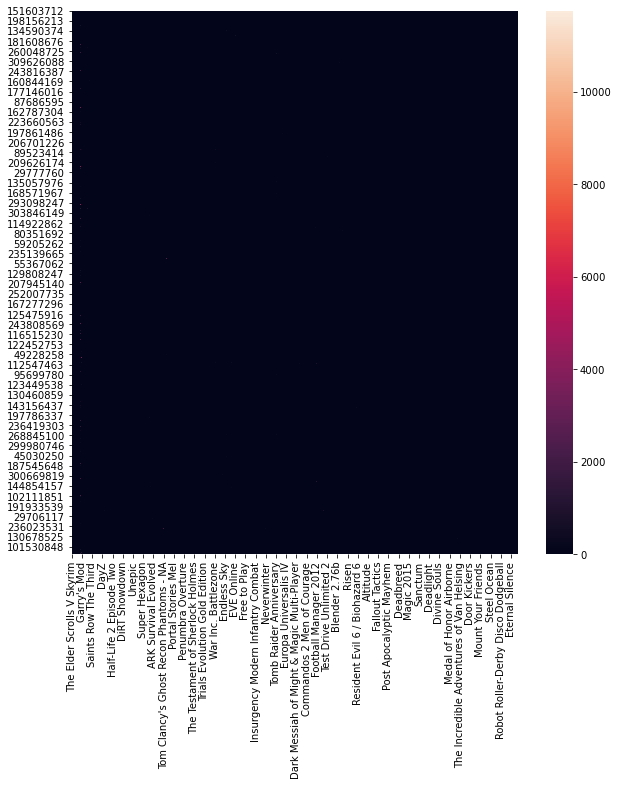

In [7]:
# Apply filters
game_playtime_thr = 5.0
user_playtime_thr = 5.0
num_user_thr = 10

drop_game_list = []
drop_user_list = []

for game in playtime_df.columns:
    playtime_total = playtime_df[game].sum()
    num_user = (playtime_df[game]>0.0).sum()
    if playtime_total<game_playtime_thr or num_user<num_user_thr:
        drop_game_list.append(game)

        
for user in playtime_df.index:
    playtime_total = playtime_df.loc[user].sum()
    if playtime_total<user_playtime_thr:
        drop_user_list.append(user) 

print(f"Before filtering: # users: {playtime_df.shape[0]}, games: {playtime_df.shape[1]}")        
# Apply filter
# ==============
playtime_df.drop(index=drop_user_list,columns=drop_game_list,inplace=True)
print(f"After filtering: # users: {playtime_df.shape[0]}, games: {playtime_df.shape[1]}")        

fig, ax = plt.subplots(1,1,figsize=[10,10])
_ = sns.heatmap(playtime_df)
# playtime_df.head()

In [8]:
# Create user_df
# ================
user_df = pd.DataFrame(dict(num_game=(playtime_df>0.0).sum(axis=1), 
                            playtime_total=(playtime_df).sum(axis=1)))

for user in playtime_df.index:
    user_df.loc[user,'playtime_000'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,0.0)
    user_df.loc[user,'playtime_p025'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,25.0)
    user_df.loc[user,'playtime_p050'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,50.0)
    user_df.loc[user,'playtime_p075'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,75.0)
    user_df.loc[user,'playtime_p100'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,100.0)
                       
                       
user_df.head()

ValueError: Incompatible indexer with Series

In [ ]:
# Create game_df
# ================
game_df = pd.DataFrame(dict(num_user=(playtime_df>0.0).sum(axis=0), 
                            playtime_total=(playtime_df).sum(axis=0)))

for game in playtime_df.columns:
    game_df.loc[game,'playtime_000' ] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,0.0)
    game_df.loc[game,'playtime_p025'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,25.0)
    game_df.loc[game,'playtime_p050'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,50.0)
    game_df.loc[game,'playtime_p075'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,75.0)
    game_df.loc[game,'playtime_p100'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,100.0)
                       
                       
game_df.head()

In [ ]:
# Create score_df
score_df = pd.DataFrame(np.zeros((len(user_df.index),len(game_df.index))),
                           index = user_df.index,
                           columns = game_df.index)
# score_df.head()
with timer('score'):
    for game in game_df.index:
    
        p025 = game_df.loc[game,'playtime_p025']
        p050 = game_df.loc[game,'playtime_p050']
        p075 = game_df.loc[game,'playtime_p075']
        
        playtimes = playtime_df.loc[:,game]
        scores = 4*np.ones(len(playtimes))
        scores[playtimes - p075<0] = 3
        scores[playtimes - p050<0] = 2
        scores[playtimes - p025<0] = 1
        scores[playtimes==0.0] = 0
        score_df.loc[:,game] = scores

fig, ax = plt.subplots(1,1,figsize=[10,10])        
_ = sns.heatmap(score_df)   

### Saving processed data


In [ ]:
playtime_df.to_csv("./Data/Steam/Processed/playtime.csv")
score_df.to_csv("./Data/Steam/Processed/score.csv")
user_df.to_csv("./Data/Steam/Processed/user.csv")
game_df.to_csv("./Data/Steam/Processed/game.csv")
